# Tutorial: ECT for Embedded Cell Complexes

This tutorial will walk you through using the `ECT` package. Particularly we will show the features of `EmbeddedComplex` class for computing the Euler Characteristic Transform on complexes with arbitrary dimensional cells.

The `EmbeddedComplex` class combines and extends the functionality of the previous `EmbeddedGraph` and `EmbeddedCW` classes, supporting **k-cells** for k ≥ 2.



In [20]:
import numpy as np
import matplotlib.pyplot as plt
from ect import EmbeddedComplex, ECT, Directions
from ect.utils.examples import create_example_graph, create_example_cw, create_example_3d_complex

## Basic Usage: Creating Simple Complexes

### Example 1: Graph (1-skeleton)

Let's start with a simple triangle graph (for legacy users this can be equivalently done using `EmbeddedGraph`). 

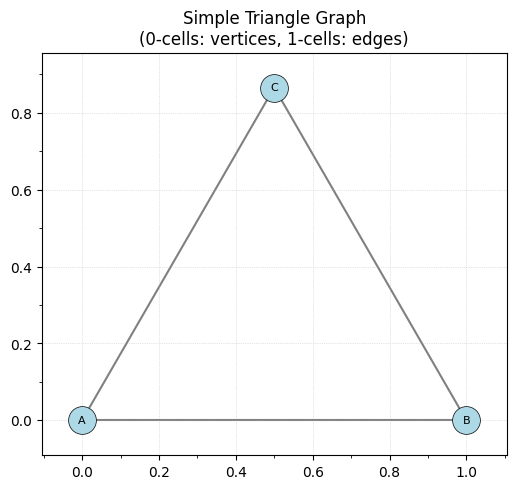

Number of nodes: 3
Number of edges: 3
Embedding dimension: 2


In [21]:
K = EmbeddedComplex()

K.add_node('A', [0, 0])
K.add_node('B', [1, 0])
K.add_node('C', [0.5, 0.866])

K.add_edge('A', 'B')
K.add_edge('B', 'C')
K.add_edge('C', 'A')

#using built-in plotting function along with matplotlib
fig, ax = plt.subplots(figsize=(6, 6))
K.plot(ax=ax, with_labels=True, node_size=400)
ax.set_title('Simple Triangle Graph\n(0-cells: vertices, 1-cells: edges)')
plt.show()

#print some information about the complex
print(f"Number of nodes: {len(K.nodes())}")
print(f"Number of edges: {len(K.edges())}")
print(f"Embedding dimension: {K.dim}")

Now let's add a 2-cell (face) to fill in the triangle:

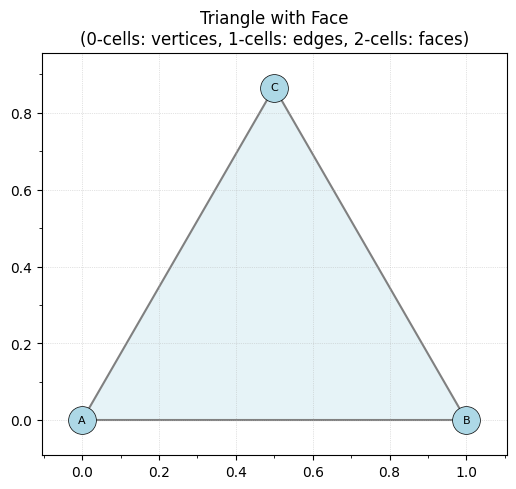

Number of 2-cells (faces): 1
Faces: [('A', 'B', 'C')]
Internal cells dictionary: {2: [(0, 1, 2)]}


In [22]:
K.add_face(['A', 'B', 'C'])

fig, ax = plt.subplots(figsize=(6, 6))
K.plot(ax=ax, with_labels=True, node_size=400, face_alpha=0.3, face_color='lightblue')
ax.set_title('Triangle with Face\n(0-cells: vertices, 1-cells: edges, 2-cells: faces)')
plt.show()

print(f"Number of 2-cells (faces): {len(K.faces)}")
print(f"Faces: {K.faces}")
print(f"Internal cells dictionary: {dict(K.cells)}")

## Adding Cells of Arbitrary Dimension

The key new feature is the ability to add cells of any dimension:

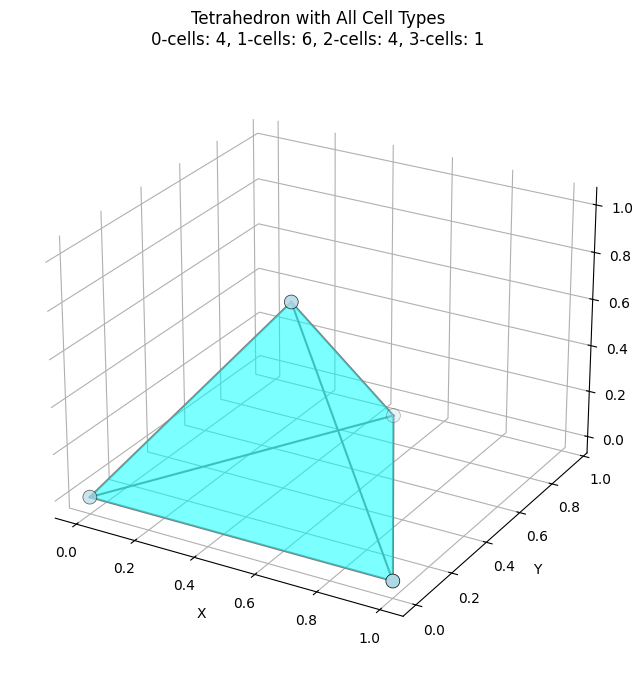

Dimension 2: 4 cells
Dimension 3: 1 cells

Total embedding dimension: 3


In [23]:
# Create a 3D tetrahedron with 0, 1, 2, and 3-cells
K_tetra = EmbeddedComplex()

# Add vertices (0-cells)
vertices = {
    'A': [0, 0, 0],
    'B': [1, 0, 0],
    'C': [0.5, 0.866, 0],
    'D': [0.5, 0.289, 0.816]  
}

for name, coord in vertices.items():
    K_tetra.add_node(name, coord)

# Add edges (1-cells) - all pairs
edges = [('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')]
K_tetra.add_edges_from(edges)

# Add faces (2-cells) - all triangular faces
faces = [['A', 'B', 'C'], ['A', 'B', 'D'], ['A', 'C', 'D'], ['B', 'C', 'D']]
for face in faces:
    K_tetra.add_cell(face, dim=2)  # Explicitly specify dimension

# Add volume (3-cell) - the entire tetrahedron
K_tetra.add_cell(['A', 'B', 'C', 'D'], dim=3)

# Plot the tetrahedron
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
K_tetra.plot(ax=ax, face_alpha=0.3, face_color='cyan', node_size=100)
ax.set_title('Tetrahedron with All Cell Types\n0-cells: 4, 1-cells: 6, 2-cells: 4, 3-cells: 1')
plt.show()

# Display cell counts
for dim in sorted(K_tetra.cells.keys()):
    print(f"Dimension {dim}: {len(K_tetra.cells[dim])} cells")
    
print(f"\nTotal embedding dimension: {K_tetra.dim}")

## ECT Computation with Higher-Dimensional Cells

The ECT computation now properly includes all cell dimensions in the Euler characteristic calculation:

**χ = Σ(-1)^k × |k-cells below threshold|**

Let's see how this works:

ECT result shape: (8, 20)
Directions: 8 directions in 3D
Thresholds: 20 threshold values


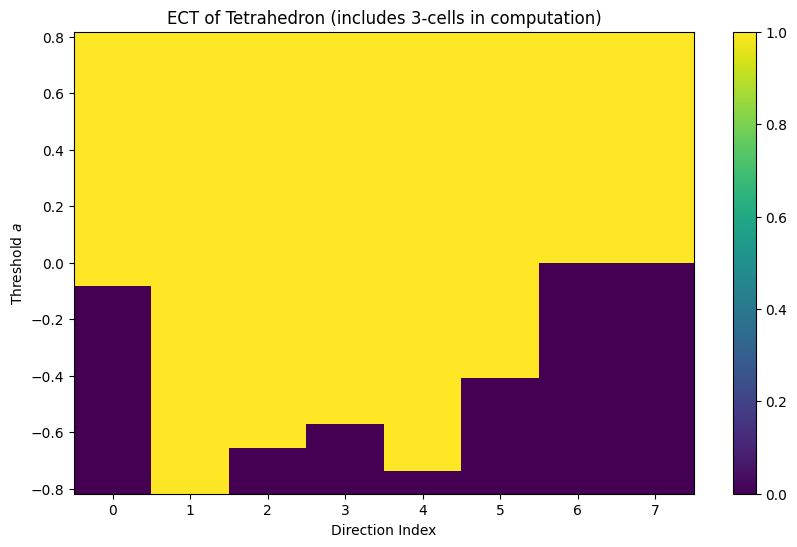

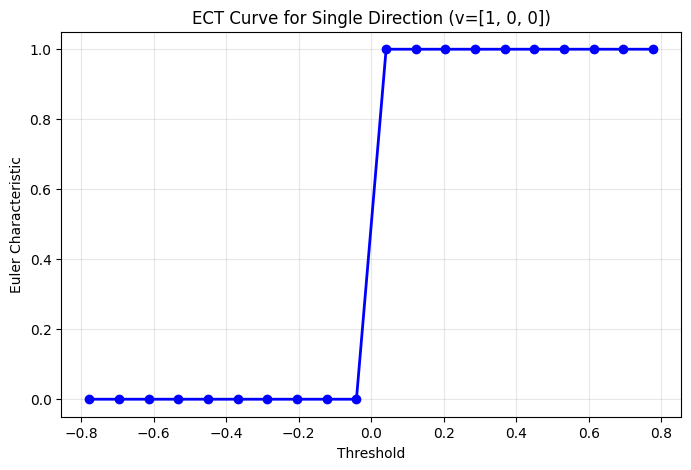

In [24]:
# Compute ECT for the tetrahedron
ect = ECT(num_dirs=8, num_thresh=20)
result = ect.calculate(K_tetra)

print(f"ECT result shape: {result.shape}")
print(f"Directions: {len(result.directions)} directions in {K_tetra.dim}D")
print(f"Thresholds: {len(result.thresholds)} threshold values")

# Plot the ECT matrix
fig, ax = plt.subplots(figsize=(10, 6))
result.plot()
plt.title('ECT of Tetrahedron (includes 3-cells in computation)')
plt.show()

single_direction = ECT(num_thresh=20, directions=Directions.from_vectors([[1, 0, 0]])).calculate(K_tetra)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(single_direction.thresholds, single_direction[0], 'b-', marker='o', linewidth=2)
ax.set_xlabel('Threshold')
ax.set_ylabel('Euler Characteristic')
ax.set_title('ECT Curve for Single Direction (v=[1, 0, 0])')
ax.grid(True, alpha=0.3)
plt.show()

## Validation System
Sometimes we need our `EmbeddedComplex` to satisfy certain constraints such as no-self intersections. You can enforce these constraints using 

Edge Interior Validation: Vertex 4 lies on edge interior
adding intersecting edge failed
4D Simplex Cell Counts:
  1-cells: 1
  2-cells: 4
  3-cells: 1


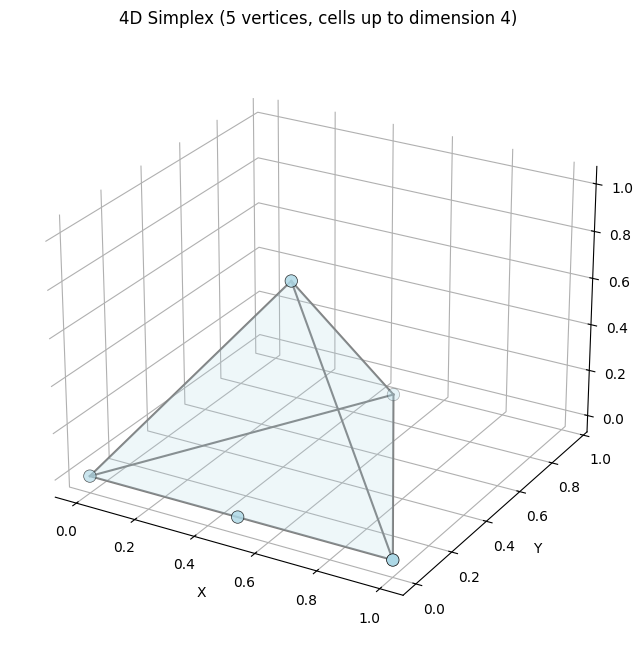

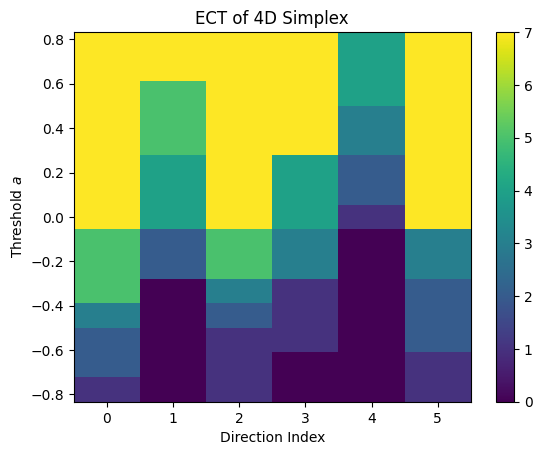

In [25]:
K_tetra.enable_embedding_validation()
#add intersecting edge
K_tetra.add_node("E", [0.5,0,0])
try:
    K_tetra.add_cell(["A", "B"], dim=1, check=True)
except Exception as e:
    print(e)
    print("adding intersecting edge failed") 

K_tetra.disable_embedding_validation()
K_tetra.add_cell(["A", "B"], dim=1)

print("4D Simplex Cell Counts:")
for dim in sorted(K_tetra.cells.keys()):
    print(f"  {dim}-cells: {len(K_tetra.cells[dim])}")

# Plot (showing 3D projection)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
K_tetra.plot(ax=ax, face_alpha=0.1, node_size=80)
ax.set_title("4D Simplex (5 vertices, cells up to dimension 4)")
plt.show()

# Compute ECT
ect_4d = ECT(num_dirs=6, num_thresh=15)
result_4d = ect_4d.calculate(K_tetra)

result_4d.plot()
plt.title("ECT of 4D Simplex")
plt.show()
